In [96]:
import os
import sys

import geopandas as gpd
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

from IPython.display import Markdown as md

from sklearn.preprocessing import PolynomialFeatures

from shapely import geometry

import dill
from functools import partial
from copy import deepcopy

from tpc import tpc_general

import seaborn as sns
import statsmodels.api as sm
from sklearn.decomposition import PCA

import warnings

sns.set(style='ticks', font_scale=1.3)
FIG_OPTIONS = {
    'figsize' : (3, 1),
    'dpi': 200
}

%matplotlib inline 

# Developing latitudinal models of $T_\mathrm{opt}, CT_\textrm{min}$ and $CT_\textrm{max}$

In [6]:
plankton_o = pd.read_csv("../../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv", engine='python')

**Filter** the data by fit quality (perhaps) and marine: 

In [7]:
# plankton = plankton_o[(plankton_o.minqual == "good") &
#                     (plankton_o.maxqual == "good") &
#                     (plankton_o.curvequal == "good")]
plankton = plankton_o[plankton_o.habitat == 'marine']

**Drop NAs**

In [8]:
plankton = plankton.dropna(
    axis=0, 
    subset=[
        'isolation.latitude',
        'isolation.longitude',
        'mu.g.opt.list', 
        'tmin', 
        'tmax'
    ]
)

Relevant parameter names/descriptions (from `../../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/Dataset explanation.doc`)
```
23) mu.wlist = estimated thermal niche width (parameter ‘ɷ’ in the thermal reaction norm model)
24) mu.alist = estimate of parameter ‘a’ in the thermal reaction norm model
25) mu.blist = estimate of parameter ‘b’ in the thermal reaction norm model
26) mu.slist = variance parameter for the maximum likelihood model fit. 
27) mu.c.opt.list = estimate of parameter ‘z’ in the thermal reaction norm model
28) mu.g.opt.val.list = estimated specific growth rate (per day) when temperature is at ‘z’ (i.e. mu.c.opt.list)
29) mu.g.opt.list = estimated optimum temperature for growth 
30) mu.g.opt.val.list = estimated maximum specific growth rate (per day) based on the thermal reaction norm model fit
31) mu.n = number of points (i.e. number of growth rate measurements) in the curve 
32) emp.max.growth = maximum specific growth rate (per day) measured during the growth assays. These were used for maximum growth rate analyses, but results did not differ significantly if estimated maximum specific growth rate based on the thermal reaction norm model fit (i.e. mu.g.opt.val.list) was used instead.
33) tmin = Tmin, or minimum persistence temperature, estimated from the thermal reaction norm model fit
34) tmax = Tmax, or maximum persistence temperature, estimated from the thermal reaction norm model fit
35) minqual = quality of Tmin estimate (quality control criteria found in supplementary info).
36) maxqual = quality of Tmax estimate (quality control criteria found in supplementary info).
37) curvequal = quality of niche width estimate (quality control criteria found in supplementary info).
38) abs.curveskew = Estimated absolute skewness of the thermal reaction norm
39) rel.curveskew = Estimated relative skewness of the thermal reaction norm
```

## $T_\mathrm{opt}$

In [9]:
topt_colname = 'mu.g.opt.list' ## 29) mu.g.opt.list = estimated optimum temperature for growth 

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(-0.6999999999999886, 0.5, 'T [deg C]')

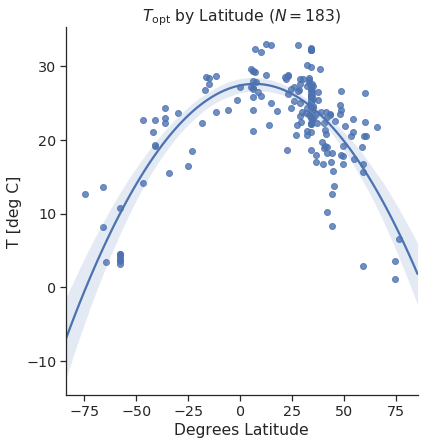

In [10]:
sns.lmplot(
    x = 'isolation.latitude',
    y = topt_colname,
    size = 6, 
    order = 2, 
    data = plankton
)
plt.title("$T_\mathrm{opt}$ by Latitude ($N = " + str(len(plankton)) + ")$")
plt.xlabel("Degrees Latitude")
plt.ylabel("T [deg C]")

### `statsmodels` fit

In [11]:
lat_column = 'isolation.latitude'

topt = plankton[topt_colname]

order2 = PolynomialFeatures(2).fit_transform(plankton[lat_column].to_numpy().reshape(-1,1))

topt_model = sm.OLS(topt, order2).fit()

topt_model.summary(title="Regular Latitude (Second order fit) Results")

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Regular Latitude (Second order fit) Results                  
==============================================================================
Dep. Variable:          mu.g.opt.list   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     143.1
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           6.41e-38
Time:                        17:06:41   Log-Likelihood:                -524.29
No. Observations:                 183   AIC:                             1055.
Df Residuals:                     180   BIC:                             1064.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.3987      0.537     51.041      0.000      26.340      28.458
x1             0.0580      0.010      5.981      0.000       0.039       0.077
x2            -0.0042      0.000    -15.965      0.000      -0.005      -0.004
==============================================================================
Omnibus:                        5.208   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                5.840
Skew:                          -0.222   Prob(JB):                       0.0539
Kurtosis:                       3.754   Cond. No.                     3.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## $T_\mathrm{min}$

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(-0.6999999999999886, 0.5, 'T [deg C]')

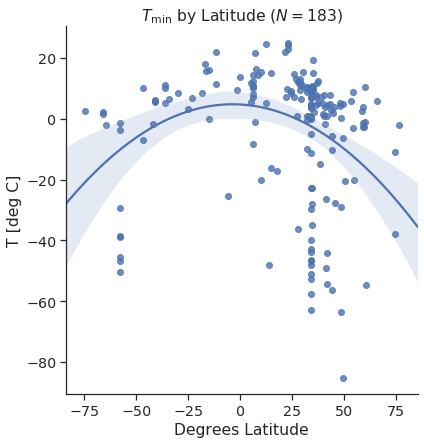

In [12]:
sns.lmplot(
    x = 'isolation.latitude',
    y = 'tmin',
    size = 6, 
    order = 2, 
    data = plankton
)
plt.title("$T_\mathrm{min}$ by Latitude ($N = " + str(len(plankton)) + ")$")
plt.xlabel("Degrees Latitude")
plt.ylabel("T [deg C]")

**Something off about that. might need a filter here**.

In [13]:
plankton_filtered = plankton[
    plankton.curvequal == 'good'
]

Text(-0.6999999999999886, 0.5, 'T [deg C]')

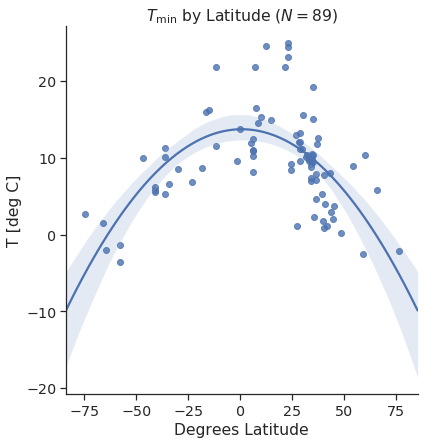

In [14]:
sns.lmplot(
    x = 'isolation.latitude',
    y = 'tmin',
    size = 6, 
    order = 2, 
    data = plankton_filtered
)
plt.title("$T_\mathrm{min}$ by Latitude ($N = " + str(len(plankton_filtered)) + ")$")
plt.xlabel("Degrees Latitude")
plt.ylabel("T [deg C]")

**Perhaps more reasonable**.
### compare `statsmodels` fits 

**1) No Data Filter**

In [15]:
lat_column = 'isolation.latitude'

tmin = plankton['tmin']

order2 = PolynomialFeatures(2).fit_transform(plankton[lat_column].to_numpy().reshape(-1,1))

tmin_model_nofilter = sm.OLS(tmin, order2).fit()

tmin_model_nofilter.summary(title="Regular Latitude (Second order fit) Results")

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Regular Latitude (Second order fit) Results                  
==============================================================================
Dep. Variable:                   tmin   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     8.300
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           0.000356
Time:                        17:06:42   Log-Likelihood:                -814.04
No. Observations:                 183   AIC:                             1634.
Df Residuals:                     180   BIC:                             1644.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7347      2.615      1.811      0.072      -0.425       9.895
x1            -0.0374      0.047     -0.793      0.429      -0.131       0.056
x2            -0.0051      0.001     -3.976      0.000      -0.008      -0.003
==============================================================================
Omnibus:                       47.804   Durbin-Watson:                   1.277
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.038
Skew:                          -1.458   Prob(JB):                     3.08e-17
Kurtosis:                       4.213   Cond. No.                     3.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**2) With filtered data**

In [16]:
lat_column = 'isolation.latitude'

tmin = plankton_filtered['tmin']

order2 = PolynomialFeatures(2).fit_transform(plankton_filtered[lat_column].to_numpy().reshape(-1,1))

tmin_model_filter = sm.OLS(tmin, order2).fit()

tmin_model_filter.summary(title="Regular Latitude (Second order fit) Results")

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Regular Latitude (Second order fit) Results                  
==============================================================================
Dep. Variable:                   tmin   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     29.88
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           1.40e-10
Time:                        17:06:43   Log-Likelihood:                -264.55
No. Observations:                  89   AIC:                             535.1
Df Residuals:                      86   BIC:                             542.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.7091      0.803     17.075      0.000      12.113      15.305
x1             0.0048      0.016      0.306      0.760      -0.026       0.036
x2            -0.0033      0.000     -7.691      0.000      -0.004      -0.002
==============================================================================
Omnibus:                        8.947   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.747
Skew:                           0.742   Prob(JB):                       0.0126
Kurtosis:                       3.395   Cond. No.                     2.78e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Compare Fits:**

In [17]:
pd.merge(
    tmin_model_filter.params.rename("Filtered"),
    tmin_model_nofilter.params.rename("Not Filtered"),
    left_index=True, right_index=True
)

,Filtered,Not Filtered
const,13.709074,4.734690
x1,0.004760,-0.037443
x2,-0.003296,-0.005088


**Compare $R^2$**

In [18]:
print(
    f"Filtered R2: {tmin_model_filter.rsquared:.3f}",
    f"Non-Filtered R2: {tmin_model_nofilter.rsquared:.3f}"
)

Filtered R2: 0.410 Non-Filtered R2: 0.084


## $T_\mathrm{max}$

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(2.1750000000000114, 0.5, 'T [deg C]')

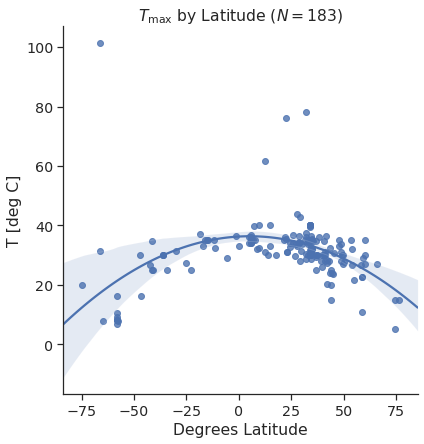

In [19]:
sns.lmplot(
    x = 'isolation.latitude',
    y = 'tmax',
    size = 6, 
    order = 2, 
    data = plankton
)
plt.title("$T_\mathrm{max}$ by Latitude ($N = " + str(len(plankton)) + ")$")
plt.xlabel("Degrees Latitude")
plt.ylabel("T [deg C]")

Text(11.300000000000011, 0.5, 'T [deg C]')

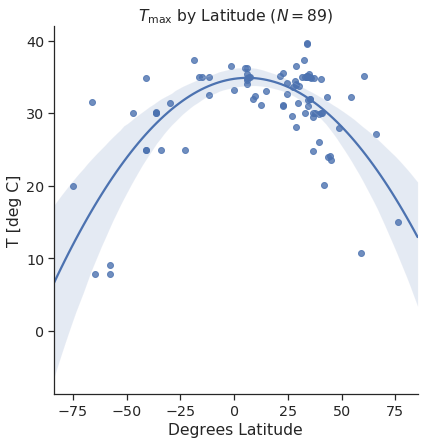

In [20]:
sns.lmplot(
    x = 'isolation.latitude',
    y = 'tmax',
    size = 6, 
    order = 2, 
    data = plankton_filtered
)
plt.title("$T_\mathrm{max}$ by Latitude ($N = " + str(len(plankton_filtered)) + ")$")
plt.xlabel("Degrees Latitude")
plt.ylabel("T [deg C]")

### Compare `statsmodels` fits

**1) No Data Filter**

In [21]:
lat_column = 'isolation.latitude'

tmax = plankton['tmax']

order2 = PolynomialFeatures(2).fit_transform(plankton[lat_column].to_numpy().reshape(-1,1))

tmax_model_nofilter = sm.OLS(tmax, order2).fit()

tmax_model_nofilter.summary(title="Regular Latitude (Second order fit) Results")

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Regular Latitude (Second order fit) Results                  
==============================================================================
Dep. Variable:                   tmax   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     22.10
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           2.61e-09
Time:                        17:06:45   Log-Likelihood:                -669.52
No. Observations:                 183   AIC:                             1345.
Df Residuals:                     180   BIC:                             1355.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.2479      1.187     30.536      0.000      33.906      38.590
x1             0.0390      0.021      1.820      0.070      -0.003       0.081
x2            -0.0037      0.001     -6.437      0.000      -0.005      -0.003
==============================================================================
Omnibus:                      224.774   Durbin-Watson:                   1.583
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11505.645
Skew:                           4.903   Prob(JB):                         0.00
Kurtosis:                      40.587   Cond. No.                     3.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**2) With Data Filter**

In [22]:
lat_column = 'isolation.latitude'

tmax = plankton_filtered['tmax']

order2 = PolynomialFeatures(2).fit_transform(plankton_filtered[lat_column].to_numpy().reshape(-1,1))

tmax_model_filter = sm.OLS(tmax, order2).fit()

tmax_model_filter.summary(title="Regular Latitude (Second order fit) Results")

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Regular Latitude (Second order fit) Results                  
==============================================================================
Dep. Variable:                   tmax   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     39.84
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           5.70e-13
Time:                        17:06:45   Log-Likelihood:                -263.00
No. Observations:                  89   AIC:                             532.0
Df Residuals:                      86   BIC:                             539.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.7413      0.789     44.031      0.000      33.173      36.310
x1             0.0425      0.015      2.780      0.007       0.012       0.073
x2            -0.0035      0.000     -8.295      0.000      -0.004      -0.003
==============================================================================
Omnibus:                        8.306   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               12.954
Skew:                          -0.328   Prob(JB):                      0.00154
Kurtosis:                       4.750   Cond. No.                     2.78e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Compare Fits:**

In [23]:
pd.merge(
    tmax_model_filter.params.rename("Filtered"),
    tmax_model_nofilter.params.rename("Not Filtered"),
    left_index=True, right_index=True
)

,Filtered,Not Filtered
const,34.741298,36.247867
x1,0.042488,0.039015
x2,-0.003494,-0.003740


Similar. 

**Compare R^2**:

In [24]:
print(
    f"Filtered R2: {tmax_model_filter.rsquared:.3f}",
    f"Non-Filtered R2: {tmax_model_nofilter.rsquared:.3f}"
)

Filtered R2: 0.481 Non-Filtered R2: 0.197


# Develop Generalized TPC function


In [72]:
def model_tpc(T, latitude, _toptModel, _tminModel, _tmaxModel): 
    from sklearn.preprocessing import PolynomialFeatures
    import num
    latitude = PolynomialFeatures(2).fit_transform(np.array(latitude).reshape(-1, 1))
    _topt = _toptModel.predict(latitude).item()
    _tmin = _tminModel.predict(latitude).item()
    _tmax = _tmaxModel.predict(latitude).item()
    

    return tpc.tpc_general(T, _topt, _tmin, _tmax)
    

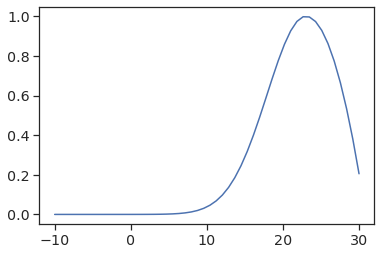

In [79]:
X = np.linspace(-10, 30)
latitude = 40
Y = model_tpc(X, latitude, topt_model, tmin_model_filter, tmax_model_filter)
plt.plot(X, Y)

In [97]:
tpc_latitudinal = partial(
    model_tpc,
    _toptModel = deepcopy(topt_model),
    _tminModel = deepcopy(tmin_model_filter), 
    _tmaxModel = deepcopy(tmax_model_filter)
)


## Save Function

In [101]:
with open("general_tpc_latitudinal.pkl", 'wb') as f:
    f.write(dill.dumps(tpc_latitudinal))

---

## Approach 2: Decomposition/Multivariate Ordination

Reference: https://github.com/HuckleyLab/ThermalStress/blob/master/ToptCTmax_analysis.R


In [24]:
axes = plankton[[topt_colname, 'tmin', 'tmax']]

In [25]:
pca = PCA()
X = pca.fit_transform(axes)

In [26]:
pca.components_.T

array([[-0.11799505,  0.40008477, -0.90885056],
       [-0.97779087, -0.20645731,  0.036061  ],
       [-0.17321138,  0.8929208 ,  0.41556018]])

In [27]:
axes.columns

Index(['mu.g.opt.list', 'tmin', 'tmax'], dtype='object')

In [28]:
weights = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(pca.components_.T.shape[1])],
    index=axes.columns)

In [29]:
weights

,PC1,PC2,PC3
mu.g.opt.list,-0.117995,0.400085,-0.908851
tmin,-0.977791,-0.206457,0.036061
tmax,-0.173211,0.892921,0.415560


In [30]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

In [31]:
loading_matrix = pd.DataFrame(
    loadings, 
    columns=[f'PC{i+1}' for i in range(pca.components_.T.shape[1])],
    index=axes.columns)

In [32]:
loading_matrix

,PC1,PC2,PC3
mu.g.opt.list,-2.602108,4.280470,-4.675060
tmin,-21.562915,-2.208868,0.185495
tmax,-3.819776,9.553277,2.137611
